<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/GANS_IN_ACTION_Chapter_5_DCGAN(Edited_to_WGAN_iter5_50000).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장: 심층 합성곱 GAN (DCGAN)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-4/Chapter_4_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
import tensorflow as tf
#print("TensorFlow version: ", tf.__version__)
#tf.debugging.set_log_device_placement(True)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#import os|
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
#os.environ["CUDA_VISIBLE_DEVICES"]='0'

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 96183355011440678
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14397635185942660063
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [2]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

## 생성자

In [3]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

## 판별자

In [4]:
#for WGAN
from keras.constraints import Constraint
from keras import backend
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

def build_discriminator(img_shape):

    const = ClipConstraint(0.01)

    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               
               kernel_constraint=const, #for WGAN

               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    #POOL
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    #POOL
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

    

## 모델 만들기

In [5]:
generator = build_generator(z_dim)
#generator.summary()
optimizer_g = tf.keras.optimizers.RMSprop(lr=1e-4)
optimizer_d = tf.keras.optimizers.RMSprop(lr=1e-4)
#optimizer_g = tf.keras.optimizers.Adam()
#optimizer_d = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean()

@tf.function
def gen_train_step(z, real):
    with tf.GradientTape() as gen_tape:
        gen_imgs = generator(z)
        pred = discriminator(gen_imgs)
        #loss_g = tf.keras.losses.binary_crossentropy(real, pred) #? real or fake?
        loss_g = -tf.math.reduce_mean(pred) #for WGAN

    gradients_g = gen_tape.gradient(loss_g, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradients_g, generator.trainable_variables))

    train_loss(loss_g)
    g_loss = train_loss.result()
    
    return gen_imgs, g_loss

@tf.function
def dis_train_step(imgs, gen_imgs, real, fake):
    with tf.GradientTape() as dis_tape:
        pred_real = discriminator(imgs)
        pred_fake = discriminator(gen_imgs)
        loss_real = tf.keras.losses.binary_crossentropy(real, pred_real)
        loss_fake = tf.keras.losses.binary_crossentropy(fake, pred_fake)
        #loss_d = (loss_real + loss_fake) /2
        loss_d = -(tf.math.reduce_mean(pred_real) -tf.math.reduce_mean(pred_fake))

    gradients_d = dis_tape.gradient(loss_d, discriminator.trainable_variables)
    optimizer_d.apply_gradients(zip(gradients_d, discriminator.trainable_variables))

    train_loss(loss_d)
    d_loss = train_loss.result()
    
    accuracy = tf.math.reduce_mean(pred_real) - tf.math.reduce_mean(pred_fake)

    return d_loss, accuracy


# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
# discriminator.compile(loss='binary_crossentropy',
#                       optimizer=Adam(),
#                       metrics=['accuracy'])

# discriminator.summary()
# # 생성자 모델 만들기
# generator = build_generator(z_dim)

# # 생성자를 훈련하는 동안 판별자의 파라미터를 유지
# discriminator.trainable = False

# # 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
# gan = build_gan(generator, discriminator)
# gan.compile(loss='binary_crossentropy', optimizer=Adam())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## 훈련

In [6]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()
    #(X_train, _), (_, _) = fashion_mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    import time
    start = time.time()  # 시작 시간 저장        

    for iteration in range(iterations):

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 판별자 훈련
        # d_loss_real = discriminator.train_on_batch(imgs, real)
        # d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        for _ in range(5):
          d_loss, accuracy = dis_train_step(imgs, gen_imgs, real, fake)

        # 생성자 훈련?
        gen_imgs, g_loss = gen_train_step(z, real)
        #_, g_loss = gen_train_step(gen_imgs, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [7]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## GAN 훈련과 출력 점검

11501568/11490434 [==============================] - 0s 0us/step
1000 [D 손실: -0.711412, 정확도: 52.09%] [G 손실: -0.711356]
time : 140.9716181755066


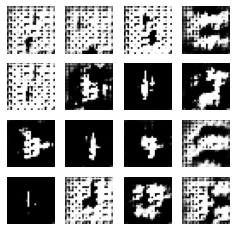

2000 [D 손실: -0.505848, 정확도: 21.55%] [G 손실: -0.505819]
time : 272.8531904220581


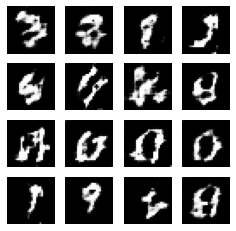

3000 [D 손실: -0.407806, 정확도: 14.69%] [G 손실: -0.407809]
time : 404.09668612480164


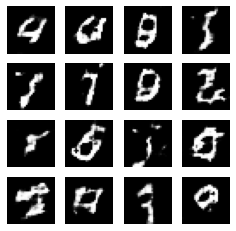

4000 [D 손실: -0.356429, 정확도: 12.78%] [G 손실: -0.356417]
time : 532.0731406211853


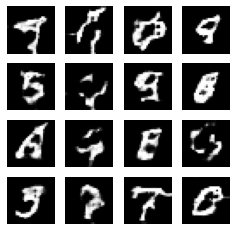

5000 [D 손실: -0.325327, 정확도: 18.74%] [G 손실: -0.325338]
time : 660.1948099136353


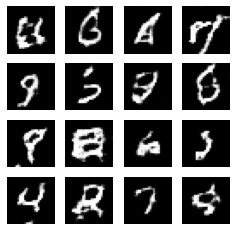

6000 [D 손실: -0.308439, 정확도: 24.27%] [G 손실: -0.308446]
time : 791.179680109024


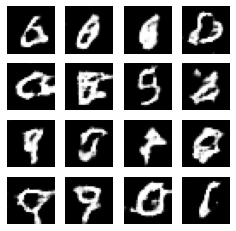

7000 [D 손실: -0.298445, 정확도: 24.50%] [G 손실: -0.298452]
time : 919.2480037212372


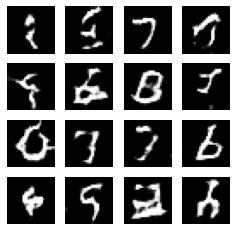

8000 [D 손실: -0.292658, 정확도: 24.24%] [G 손실: -0.292654]
time : 1047.5589962005615


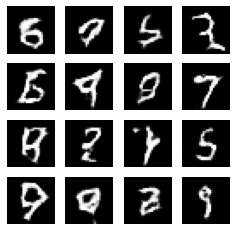

9000 [D 손실: -0.288146, 정확도: 19.86%] [G 손실: -0.288152]
time : 1176.0253548622131


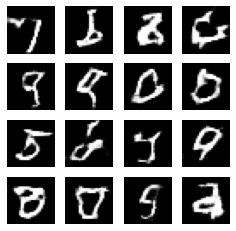

10000 [D 손실: -0.284943, 정확도: 21.99%] [G 손실: -0.284947]
time : 1302.1961417198181


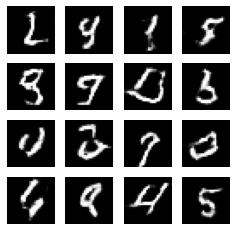

11000 [D 손실: -0.283231, 정확도: 26.72%] [G 손실: -0.283229]
time : 1430.4300158023834


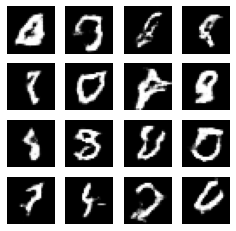

12000 [D 손실: -0.281432, 정확도: 22.41%] [G 손실: -0.281435]
time : 1557.3295502662659


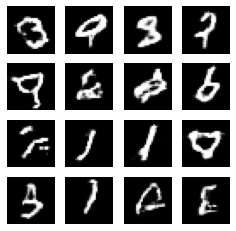

13000 [D 손실: -0.280089, 정확도: 33.43%] [G 손실: -0.280090]
time : 1683.6846272945404


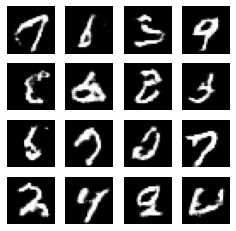

14000 [D 손실: -0.279369, 정확도: 15.71%] [G 손실: -0.279368]
time : 1808.9972462654114


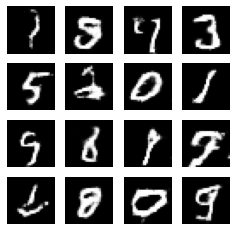

15000 [D 손실: -0.278874, 정확도: 23.18%] [G 손실: -0.278877]
time : 1934.6309659481049


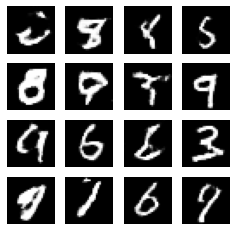

16000 [D 손실: -0.278614, 정확도: 32.30%] [G 손실: -0.278616]
time : 2062.7581424713135


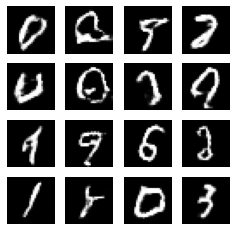

17000 [D 손실: -0.278607, 정확도: 41.43%] [G 손실: -0.278611]
time : 2187.9535298347473


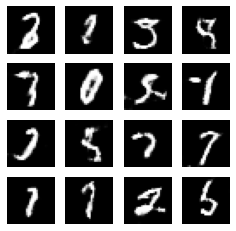

18000 [D 손실: -0.278544, 정확도: 38.05%] [G 손실: -0.278545]
time : 2312.1963229179382


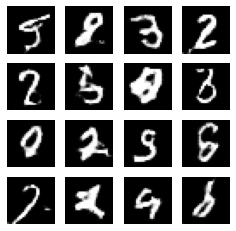

19000 [D 손실: -0.278798, 정확도: 18.53%] [G 손실: -0.278800]
time : 2436.1604499816895


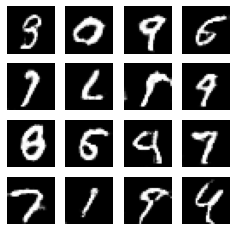

20000 [D 손실: -0.279013, 정확도: 29.97%] [G 손실: -0.279018]
time : 2559.457682132721


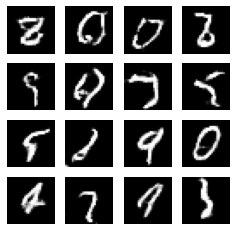

21000 [D 손실: -0.279237, 정확도: 38.72%] [G 손실: -0.279239]
time : 2683.6274638175964


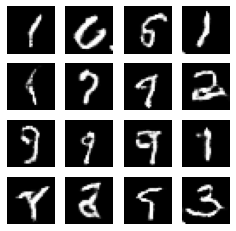

22000 [D 손실: -0.279696, 정확도: 35.73%] [G 손실: -0.279694]
time : 2808.7292563915253


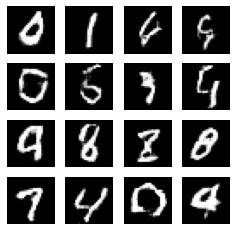

23000 [D 손실: -0.280048, 정확도: 27.00%] [G 손실: -0.280047]
time : 2932.959370613098


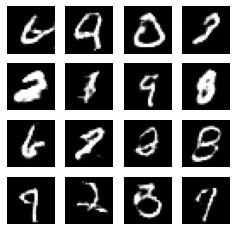

24000 [D 손실: -0.280373, 정확도: 28.66%] [G 손실: -0.280374]
time : 3057.824060201645


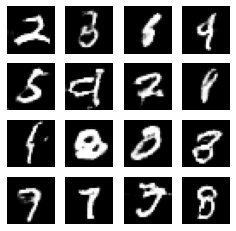

25000 [D 손실: -0.280662, 정확도: 33.93%] [G 손실: -0.280661]
time : 3182.18826007843


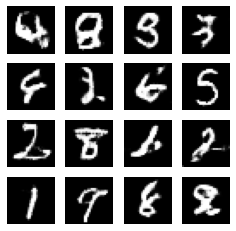

26000 [D 손실: -0.280884, 정확도: 31.45%] [G 손실: -0.280884]
time : 3306.6393036842346


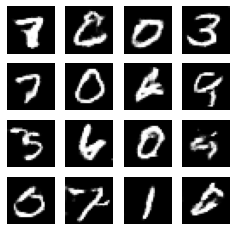

27000 [D 손실: -0.280992, 정확도: 35.39%] [G 손실: -0.280990]
time : 3431.0843334198


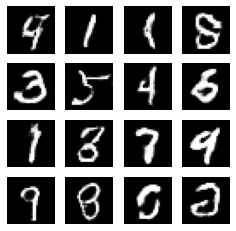

28000 [D 손실: -0.281130, 정확도: 44.57%] [G 손실: -0.281129]
time : 3555.196659564972


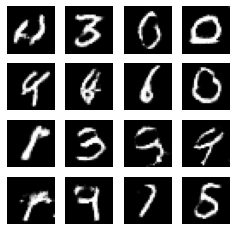

29000 [D 손실: -0.281306, 정확도: 23.25%] [G 손실: -0.281307]
time : 3678.479211330414


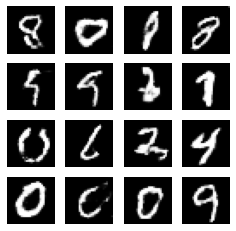

30000 [D 손실: -0.281500, 정확도: 30.66%] [G 손실: -0.281500]
time : 3801.37606549263


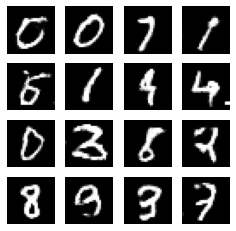

31000 [D 손실: -0.281687, 정확도: 24.71%] [G 손실: -0.281686]
time : 3925.0049188137054


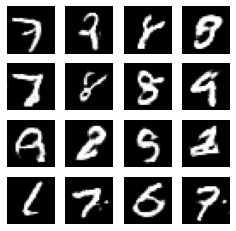

32000 [D 손실: -0.281901, 정확도: 36.43%] [G 손실: -0.281901]
time : 4050.485018491745


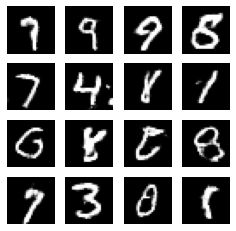

33000 [D 손실: -0.282136, 정확도: 40.63%] [G 손실: -0.282137]
time : 4174.210589885712


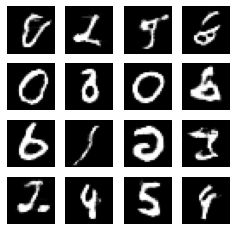

34000 [D 손실: -0.282406, 정확도: 29.49%] [G 손실: -0.282405]
time : 4297.632275104523


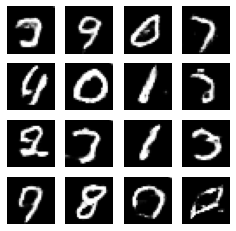

35000 [D 손실: -0.282669, 정확도: 27.72%] [G 손실: -0.282668]
time : 4420.844772815704


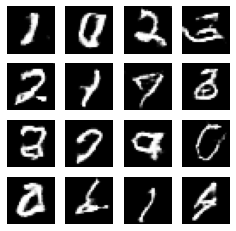

36000 [D 손실: -0.282950, 정확도: 37.97%] [G 손실: -0.282950]
time : 4543.81177854538


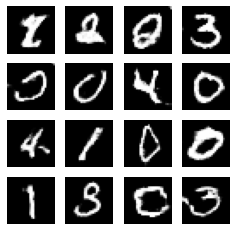

37000 [D 손실: -0.283284, 정확도: 43.83%] [G 손실: -0.283283]
time : 4668.86549782753


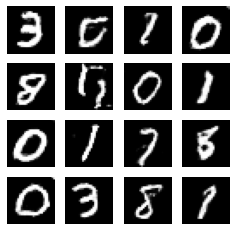

38000 [D 손실: -0.283511, 정확도: 28.06%] [G 손실: -0.283510]
time : 4793.887756586075


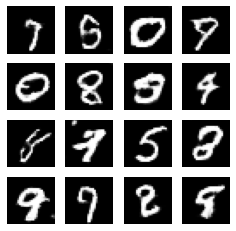

39000 [D 손실: -0.283740, 정확도: 30.99%] [G 손실: -0.283741]
time : 4918.184658288956


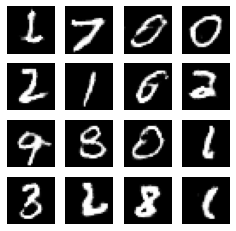

40000 [D 손실: -0.284055, 정확도: 21.37%] [G 손실: -0.284054]
time : 5043.199106693268


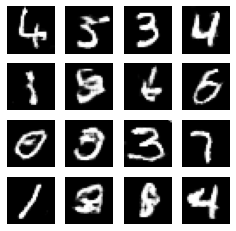

41000 [D 손실: -0.284285, 정확도: 25.37%] [G 손실: -0.284286]
time : 5169.104743480682


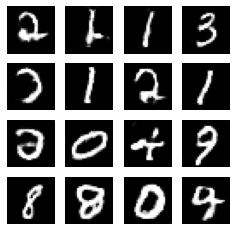

42000 [D 손실: -0.284454, 정확도: 33.14%] [G 손실: -0.284454]
time : 5296.1788029670715


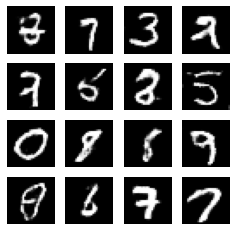

43000 [D 손실: -0.284622, 정확도: 36.58%] [G 손실: -0.284623]
time : 5420.910884380341


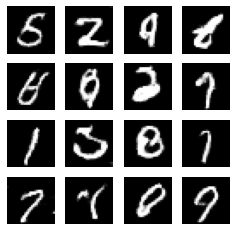

44000 [D 손실: -0.284743, 정확도: 36.87%] [G 손실: -0.284742]
time : 5546.648436784744


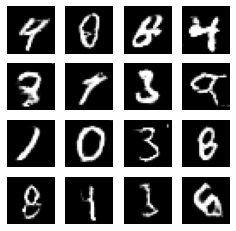

45000 [D 손실: -0.284993, 정확도: 33.18%] [G 손실: -0.284993]
time : 5671.375932216644


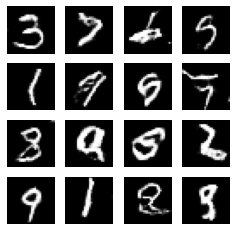

In [ ]:
# 하이퍼파라미터 설정
iterations = 50000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)

In [ ]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [ ]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()